<a href="https://colab.research.google.com/github/Siuuuuuu0/ML-DL/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification
# Data Initialization

In [1]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns

from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from sklearn.metrics import confusion_matrix

n_samples = 1000

X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=52
)

cms = {}

In [2]:
X

array([[-0.7409712 ,  0.61073201],
       [-0.16518405,  0.77979567],
       [ 0.16356163,  0.98122242],
       ...,
       [ 0.75622395,  0.24874819],
       [-0.74391164, -0.24503487],
       [-0.40766441,  0.65757212]])

In [3]:
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y
                        })

circles.head()

,X1,X2,label
0,-0.740971,0.610732,0
1,-0.165184,0.779796,1
2,0.163562,0.981222,0
3,0.041243,0.823617,1
4,-0.645638,-0.729016,0


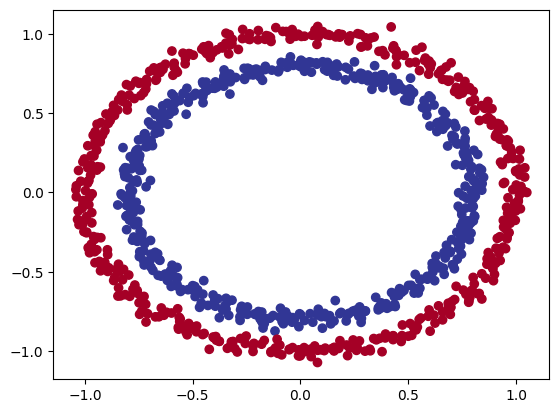

In [4]:
plt.scatter(
    x=X[:, 0],
    y=X[:, 1],
    c=y,
    cmap=plt.cm.RdYlBu
)

In [5]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

# Pytorch Model

In [6]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=52)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=8)
    self.layer_2 = nn.Linear(in_features=8, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [9]:
next(model_0.parameters()).device

device(type='cpu')

In [10]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=1)
).to(device)

In [11]:
with torch.inference_mode():
  untrained_preds = model(X_test.to(device))
print(f"Predictions {untrained_preds[:10]}")
print(f"First labels {y_test[:10]}")

Predictions tensor([[-0.1442],
        [-0.2071],
        [-0.2033],
        [-0.1677],
        [-0.3014],
        [-0.2708],
        [-0.3266],
        [-0.2255],
        [-0.1539],
        [-0.2373]])
First labels tensor([0., 1., 0., 1., 1., 1., 0., 0., 1., 1.])


In [12]:
loss_fn = nn.BCEWithLogitsLoss()
# Calculate the Logits (raw outputs from the final layer of the model)

# Take the softmax of logits.

# Take the log of outputs from step-2.

# Calculate F.nll_loss which is simply indexing as shown before, by passing in outputs from step-3 and your target values.

# BCE simple doesnt include sigmoid fn, and sigmid with BCE apart less numerically stable

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
   correct = torch.eq(y_true, y_pred).sum().item()
   acc = (correct/len(y_pred)) * 100
   return acc

In [13]:
model.eval()
with torch.inference_mode():
   y_logits = model(X_test.to(device))[:5]
y_logits

tensor([[-0.1442],
        [-0.2071],
        [-0.2033],
        [-0.1677],
        [-0.3014]])

In [14]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4640],
        [0.4484],
        [0.4493],
        [0.4582],
        [0.4252]])

In [15]:
y_preds = torch.round(y_pred_probs)

y_preds

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [16]:
epochs = 1000

accs = []
losses = []

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model.train()

  y_logits = model(X_train).squeeze()

  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, #BCEWithLogits so pasing logits
                 y_train)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 10 == 0:
      # print(f"Epoch {epoch}, Loss {loss}, Acc {acc}, Test Loss {test_loss}, Test Acc {test_acc}")
      accs.append(test_acc)
      losses.append(test_loss)


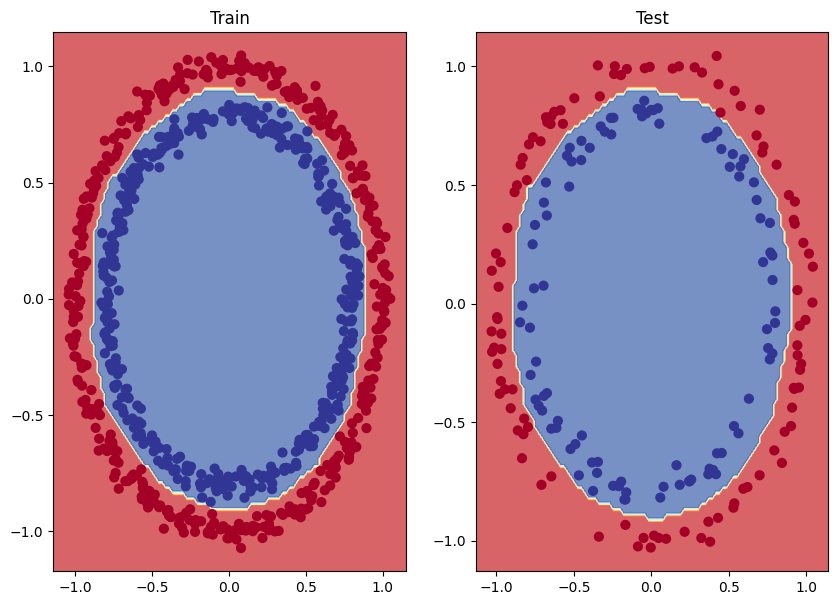

In [17]:
import numpy as np
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

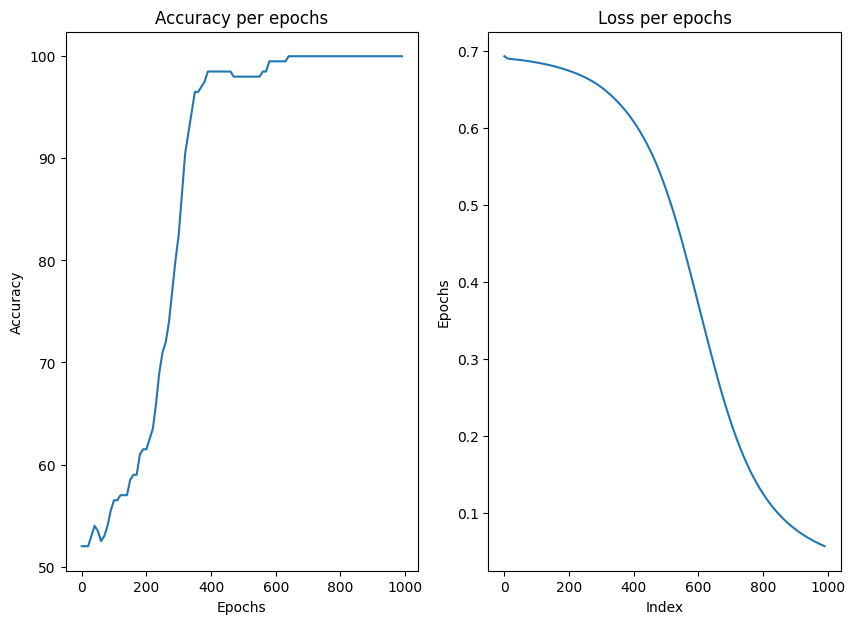

In [18]:
df = pd.DataFrame({"Index":np.arange(start=0, stop=epochs, step=10), "Loss":losses, "Accuracy":accs})

plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.plot(df['Index'], df['Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per epochs')

plt.subplot(1, 2, 2)
plt.plot(df['Index'], df['Loss'])
plt.xlabel('Index')
plt.ylabel('Epochs')
plt.title('Loss per epochs')

plt.show()

In [19]:
cm = confusion_matrix(y_test.detach().numpy(), test_pred.detach().numpy())
cms["Pytorch model"] = cm

# Sklearn Logistic Regression

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Non linear data, so adding a new non linear feature
# Transforming w1​x+w2​y+b=0 into w1x+w2y+b+w3(x^2+y^2)=0

X_new = np.column_stack([X, X[:,0]**2 + X[:,1]**2])

# Standardising, as the sum of squares might be significantly higher or lower (for values <1)
# than other features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_new)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=52)

In [22]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [23]:
y_pred = model.predict(X_test)
model.score(X_test, y_test)

1.0

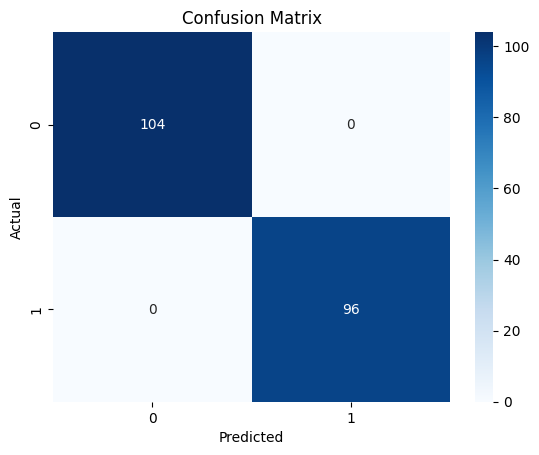

In [24]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [25]:
cms["Logistic Regression"] = cm

# Models Comparison

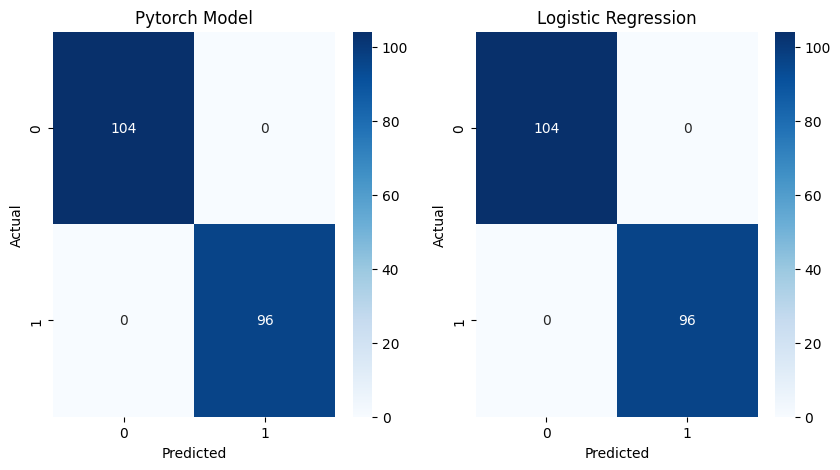

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.heatmap(cms['Pytorch model'], annot=True, fmt="g", cmap="Blues", ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Pytorch Model")

sns.heatmap(cms['Logistic Regression'], annot=True, fmt="g", cmap="Blues", ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("Logistic Regression")

plt.show()

# Multiclass Classification

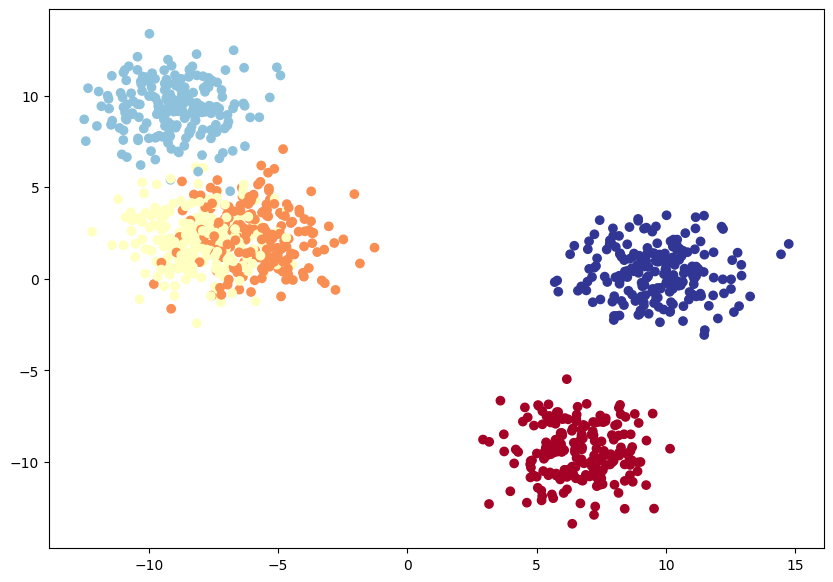

In [27]:
from sklearn.datasets import make_blobs

NUM_CLASSES = 5
NUM_FEATURES = 2
RANDOM_SEED = 52

X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state = RANDOM_SEED
                            )

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size = 0.2,
                                                    random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model = BlobModel(input_features = 2,
                  output_features = 5,
                  hidden_units = 8).to(device)

model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=5, bias=True)
  )
)

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)



In [31]:
model.eval()
with torch.inference_mode():
  y_pred = model(X_test.to(device))
torch.argmax(torch.softmax(y_pred, dim=1), dim=1)[:10]

tensor([4, 0, 1, 2, 0, 3, 3, 2, 4, 0])

In [32]:
epochs = 1000

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

accs = []
losses = []

for epoch in range(epochs):
  model.train()

  y_logits = model(X_train)

  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model.eval()

  with torch.inference_mode():
    test_logits = model(X_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_preds)

    if epoch % 10 == 0:
      losses.append(test_loss)
      accs.append(test_acc)

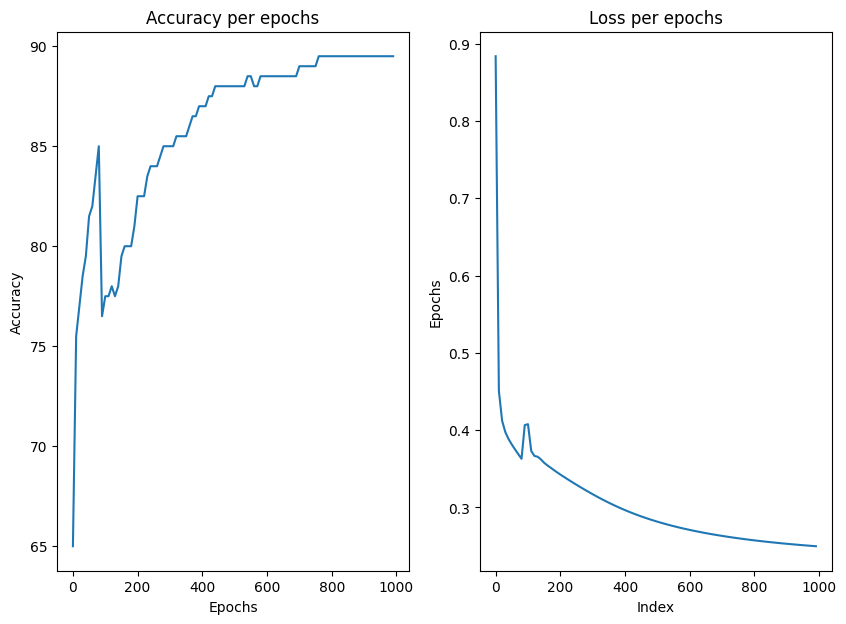

In [33]:
df = pd.DataFrame({"Index":np.arange(start=0, stop=epochs, step=10), "Loss":losses, "Accuracy":accs})

plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.plot(df['Index'], df['Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per epochs')

plt.subplot(1, 2, 2)
plt.plot(df['Index'], df['Loss'])
plt.xlabel('Index')
plt.ylabel('Epochs')
plt.title('Loss per epochs')

plt.show()

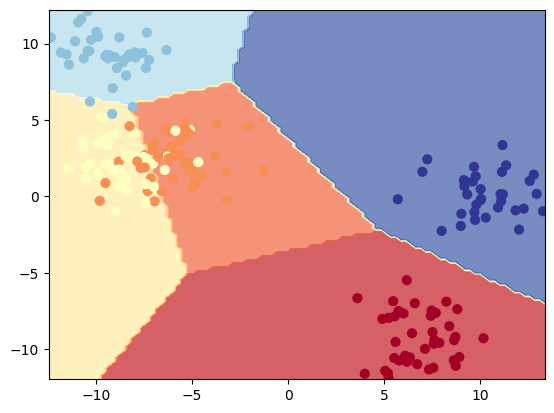

In [34]:
plot_decision_boundary(model, X_test, y_test)

In [35]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 44.9 MB/s eta 0:00:00


In [36]:
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

torchmetrics_accuracy(test_preds, y_test)

tensor(0.8950)